In [ ]:
!pip install rdkit-pypi

In [ ]:
!pip install PyTDC

     |████████████████████████████████| 88 kB 4.8 MB/s 
  Created wheel for PyTDC: filename=PyTDC-0.3.6-py3-none-any.whl size=120882 sha256=359dd5da4875f4cb6f43b44c27d33f098dcac1cc873ac8d198ee2d7c7a79fe4f
  Stored in directory: /root/.cache/pip/wheels/c3/54/29/38349b4cf57cda21a1493f61721a6d72b232061f7665102d47
Successfully built PyTDC


In [ ]:
# importing required libraries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from scipy.stats import loguniform
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem import DataStructs
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem
from rdkit import Chem
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

### Dataset Curation and Cleaning

In [ ]:
from tdc.single_pred import ADME
data = ADME(name = 'CYP2C19_Veith')
split = data.get_split(method = 'scaffold')

Found local copy...
Loading...
Done!
100%|██████████| 12665/12665 [00:04<00:00, 2969.44it/s]


In [ ]:
# randomized
df_train = split['train']
df_test = split['test']
df_valid = split['valid']

In [ ]:
print('length of training dataset: ', len(df_train))
print('length of testing dataset: ', len(df_test))
print('length of validation dataset: ', len(df_valid))

length of training dataset:  8866
length of testing dataset:  2533
length of validation dataset:  1266


In [ ]:
df_train.columns

Index(['Drug_ID', 'Drug', 'Y'], dtype='object')

In [ ]:
def getMolecularWeight(df):
  molecular_wt_list = []
  mol_list = []
  Y_list = []

  for count, mol in enumerate(df['Drug']):
    molecular_wt_list.append(ExactMolWt(Chem.MolFromSmiles(mol)))
    mol_list.append(mol)
    Y_list.append(df['Y'][count])
  
  df_new = pd.DataFrame(data = {'Drug': mol_list, 'Molecular Weight' : molecular_wt_list, 'Y' : Y_list})


  return df_new

In [ ]:
# outlier removal by weight 
# first get molecular weight
df_new_train = getMolecularWeight(df_train)
df_new_test = getMolecularWeight(df_test)
df_new_valid = getMolecularWeight(df_valid)

In [ ]:
print('length of training dataset: ', len(df_new_train))
print('length of testing dataset: ', len(df_new_test))
print('length of validation dataset: ', len(df_new_valid))

length of training dataset:  8866
length of testing dataset:  2533
length of validation dataset:  1266


In [ ]:
df_final_con = pd.concat([df_new_train, df_new_test, df_new_valid], ignore_index=True)

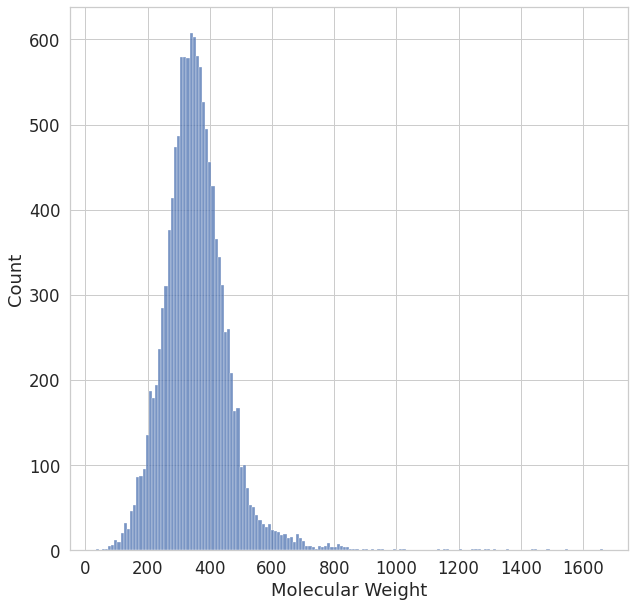

In [ ]:
sns.histplot(df_final_con['Molecular Weight'])

In [ ]:
def outlierRemoval(df):
  # calculate summary statistics
  data_mean, data_std = mean(df['Molecular Weight']), std(df['Molecular Weight'])
  # identify outliers
  cut_off = data_std * 3
  lower, upper = data_mean - cut_off, data_mean + cut_off

  outliers = [x for x in df['Molecular Weight'] if x < lower or x > upper]

  loc_outliers = []
  for i in outliers:
    idx = df.loc[(df['Molecular Weight'] == i)]
    # print(idx.index[0])
    loc_outliers.append(idx.index[0])
  
  df = df.drop(loc_outliers)
  df = df.reset_index()

  return df

In [ ]:
df_train_outlier = outlierRemoval(df_new_train)
df_test_outlier = outlierRemoval(df_new_test)
df_valid_outlier = outlierRemoval(df_new_valid)

In [ ]:
print('length after outlier removal: ')
print('length of training dataset: ', len(df_train_outlier))
print('length of testing dataset: ', len(df_test_outlier))
print('length of validation dataset: ', len(df_valid_outlier))

length after outlier removal: 
length of training dataset:  8772
length of testing dataset:  2503
length of validation dataset:  1251


In [ ]:
df_final_con = pd.concat([df_train_outlier, df_test_outlier, df_valid_outlier], ignore_index=True)

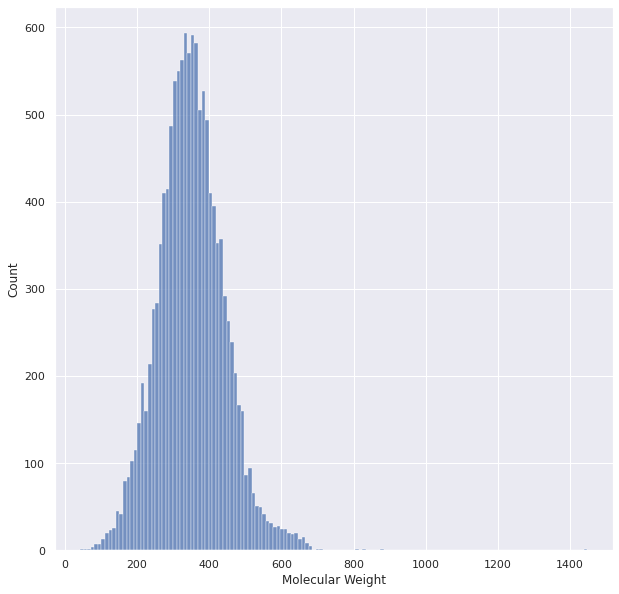

In [ ]:
sns.histplot(df_final_con['Molecular Weight'])

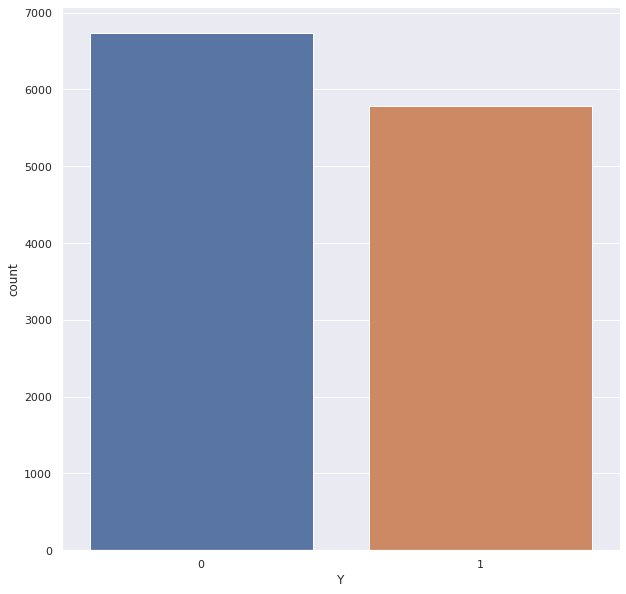

In [ ]:
sns.countplot(x='Y', data=df_final_con)

In [ ]:
def mol2arr(mol, radi=2, nBits=1024):
    arr = np.zeros((0,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radi, nBits)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


In [ ]:
# check for invalid SMILES string and create dataset with ECFP4 fingerprint

def getArrdf(df):
  Y_list = []
  molvec = []
  for count in range(len(df)):
    mol = df['Drug'][count]
    if(Chem.MolFromSmiles(mol) == None):
      print('Error at ', count)
    else:
      molvec.append(mol2arr(Chem.MolFromSmiles(mol)))
      Y_list.append(df['Y'][count])

  df_new = pd.DataFrame(list(map(np.ravel, molvec)))
  df_new['Y'] = Y_list

  return df_new


In [ ]:
df_final_train = getArrdf(df_train_outlier)
df_final_test = getArrdf(df_test_outlier)
df_final_valid = getArrdf(df_valid_outlier)

In [ ]:
df_final_train

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
8768,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
8769,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
8770,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [ ]:
df_final_train.to_csv('train_CYP3A4.csv')
df_final_test.to_csv('test_CYP3A4.csv')
df_final_valid.to_csv('valid_CYP3A4.csv')

### Logistic Regression

In [ ]:
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

In [ ]:
search = RandomizedSearchCV(reg_log, space, scoring='accuracy', n_jobs=-1, cv=cv, verbose = 3)

In [ ]:
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 30 folds for each of 10 candidates, totalling 300 fits
Best Score: 0.7658459371312261
Best Hyperparameters: {'C': 0.003656145382963658, 'penalty': 'none', 'solver': 'newton-cg'}


In [ ]:
reg_log = LogisticRegression(C = 0.003656145382963658, solver = 'newton-cg', penalty = 'none')
reg_log.fit(X_train, y_train)
y_pred_test = reg_log.predict(X_test)
y_pred_valid = reg_log.predict(X_valid)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"


In [ ]:
roc_auc_score(y_test, reg_log.decision_function(X_test))

0.8375046440742898

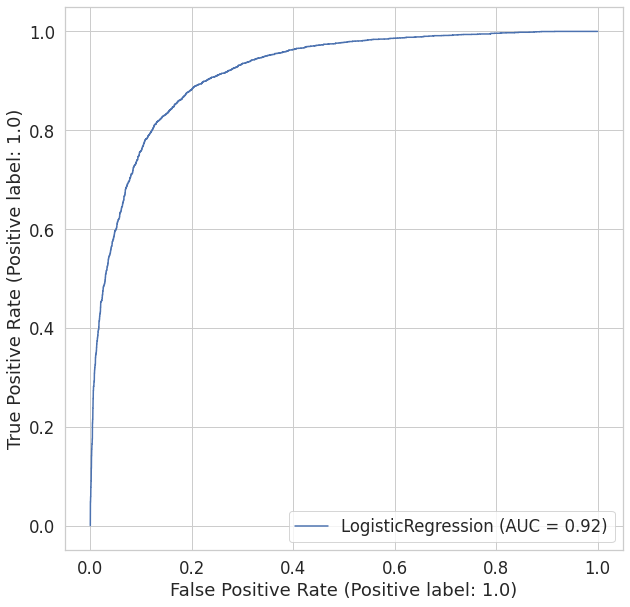

In [ ]:
RocCurveDisplay.from_estimator(reg_log , X_train, y_train)

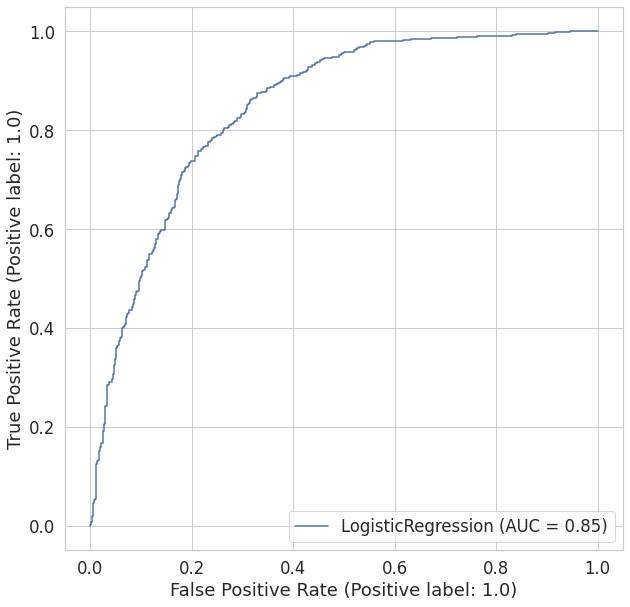

In [ ]:
RocCurveDisplay.from_estimator(reg_log , X_valid, y_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


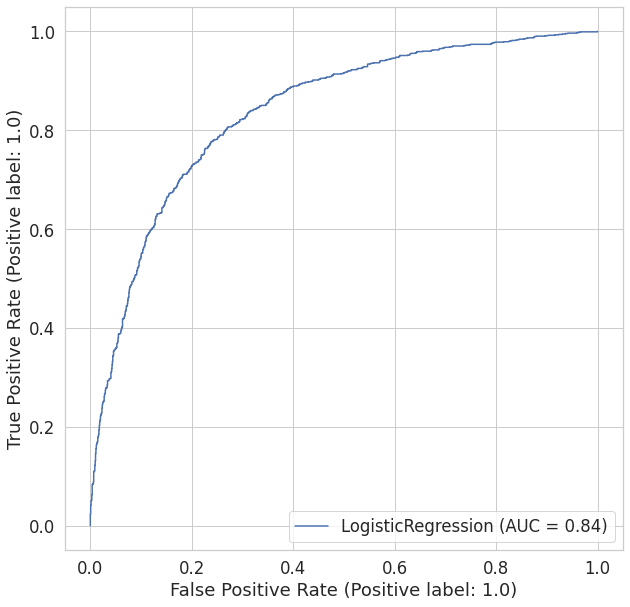

In [ ]:
metrics.plot_roc_curve(reg_log, X_test, y_test)

In [ ]:
matthews_corrcoef(y_test, y_pred_test)

0.5272165510835644

In [ ]:
matthews_corrcoef(y_valid, y_pred_valid)

0.5375248351326705

In [ ]:
y_pred_train = reg_log.predict(X_train)

In [ ]:
matthews_corrcoef(y_train, y_pred_train)

0.6834153192678125

In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85      4723
         1.0       0.83      0.83      0.83      4049

    accuracy                           0.84      8772
   macro avg       0.84      0.84      0.84      8772
weighted avg       0.84      0.84      0.84      8772



In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78      1354
         1.0       0.75      0.74      0.74      1149

    accuracy                           0.77      2503
   macro avg       0.76      0.76      0.76      2503
weighted avg       0.77      0.77      0.77      2503



In [ ]:
print(classification_report(y_valid, y_pred_valid))


              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78       662
         1.0       0.76      0.74      0.75       589

    accuracy                           0.77      1251
   macro avg       0.77      0.77      0.77      1251
weighted avg       0.77      0.77      0.77      1251



### Random Forests

In [ ]:
param_grid = { 
    'n_estimators': [10, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=reg_rf, param_grid=param_grid, cv= 2, verbose=2)
CV_rfc.fit(X_train, y_train)


Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=10; total time=   0.2s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=10; total time=   0.2s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=   6.3s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=   5.6s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=10; total time=   0.2s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=10; total time=   0.2s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500; total time=   4.4s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500; total time=   4.5s
[CV] END criterion=gini, max_depth=4, max_features=log2, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=4, max_features=log2, n_estimators=10; total time=   0.1s
[CV] 

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [4, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 500]},
             verbose=2)

In [ ]:
CV_rfc

In [ ]:
CV_rfc.best_params_


{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 500}

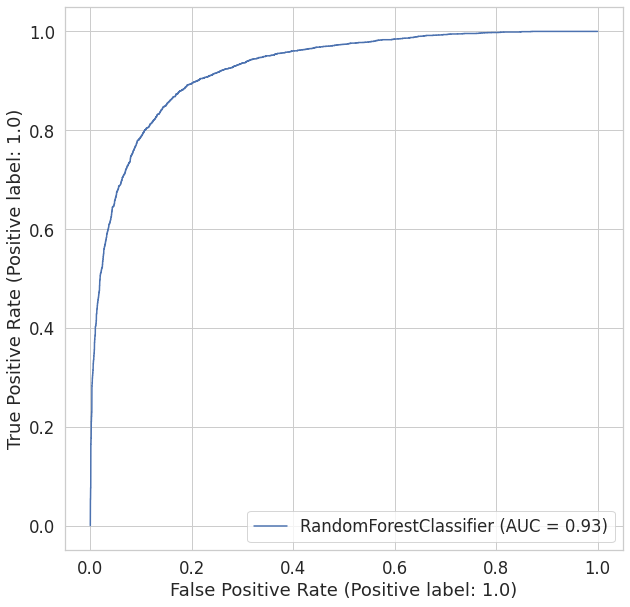

In [ ]:
RocCurveDisplay.from_estimator(reg_rf , X_train, y_train)

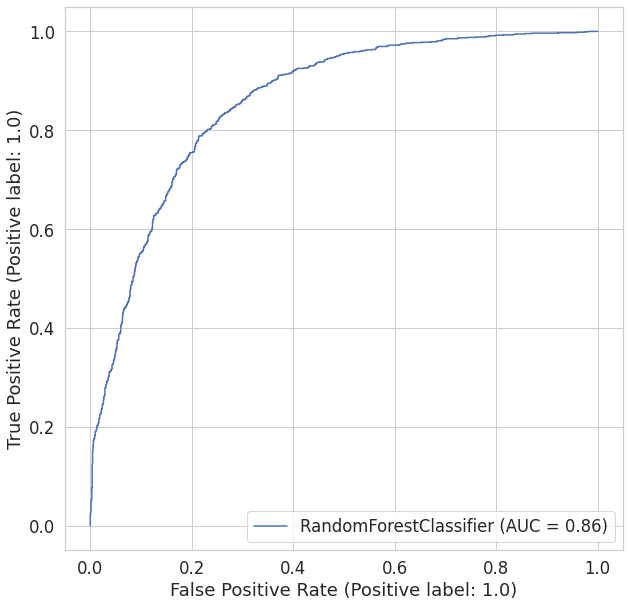

In [ ]:
RocCurveDisplay.from_estimator(reg_rf , X_test, y_test)

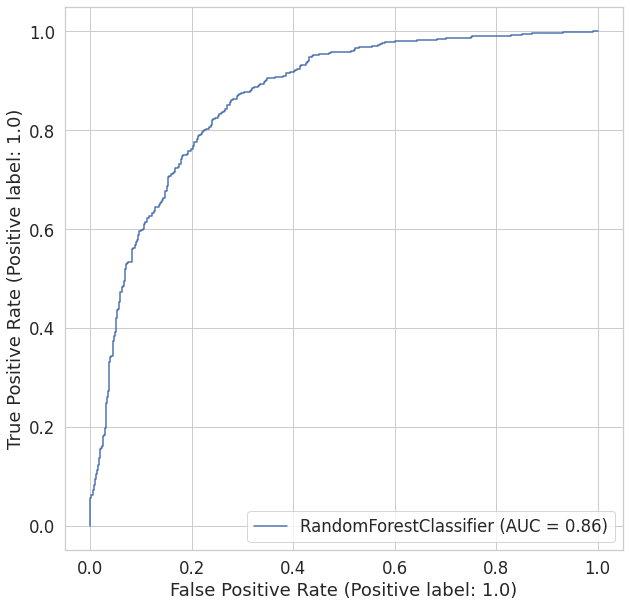

In [ ]:
RocCurveDisplay.from_estimator(reg_rf , X_valid, y_valid)

In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86      4723
         1.0       0.82      0.87      0.84      4049

    accuracy                           0.85      8772
   macro avg       0.85      0.85      0.85      8772
weighted avg       0.85      0.85      0.85      8772



In [ ]:
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79      1354
         1.0       0.74      0.80      0.77      1149

    accuracy                           0.78      2503
   macro avg       0.78      0.78      0.78      2503
weighted avg       0.78      0.78      0.78      2503



In [ ]:
print(classification_report(y_valid, y_pred_valid))


              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79       662
         1.0       0.76      0.80      0.78       589

    accuracy                           0.79      1251
   macro avg       0.79      0.79      0.79      1251
weighted avg       0.79      0.79      0.79      1251



In [ ]:
matthews_corrcoef(y_test, y_pred_test)

0.565078689497941

In [ ]:
matthews_corrcoef(y_valid, y_pred_valid)

0.5732981419376812

In [ ]:
matthews_corrcoef(y_train, y_pred_train)

0.7016762338247211

### XGBoost

In [ ]:
params = {
        'n_estimators': [100, 500, 1000],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 8]
        }


In [ ]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=4, random_state=1001 )

# Here we go
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f6b3b80d150>,
                   estimator=XGBClassifier(colsample_bytree=0.8, gamma=1.5,
                                           max_depth=8, min_child_weight=10,
                                           n_estimators=500, random_state=1001,
                                           subsample=0.8),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [4, 8],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=1001, scoring='roc_auc', verbose=4)

In [ ]:
print('\n Best estimator:')
print(random_search.best_estimator_)


 Best estimator:
XGBClassifier(colsample_bytree=0.8, gamma=1.5, max_depth=8, min_child_weight=10,
              n_estimators=500, random_state=1001, subsample=0.8)


In [ ]:
random_search.best_score_

0.8674543137599665

In [ ]:
xgb_model = xgb.XGBClassifier(colsample_bytree=0.5, max_depth=4, min_child_weight=3,
              n_estimators=100, subsample=0.5)
xgb_model.fit(X_train, y_train)

y_pred_test_xgb = xgb_model.predict(X_test)

In [ ]:
y_pred_valid_xgb = xgb_model.predict(X_valid)

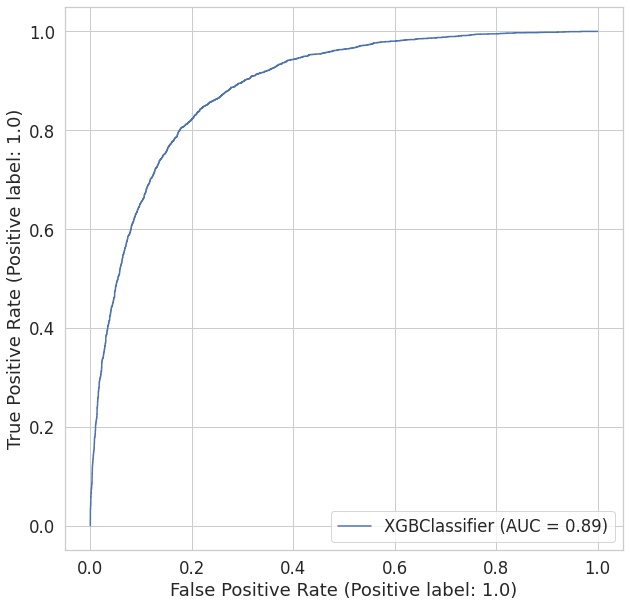

In [ ]:
RocCurveDisplay.from_estimator(xgb_model , X_train, y_train)

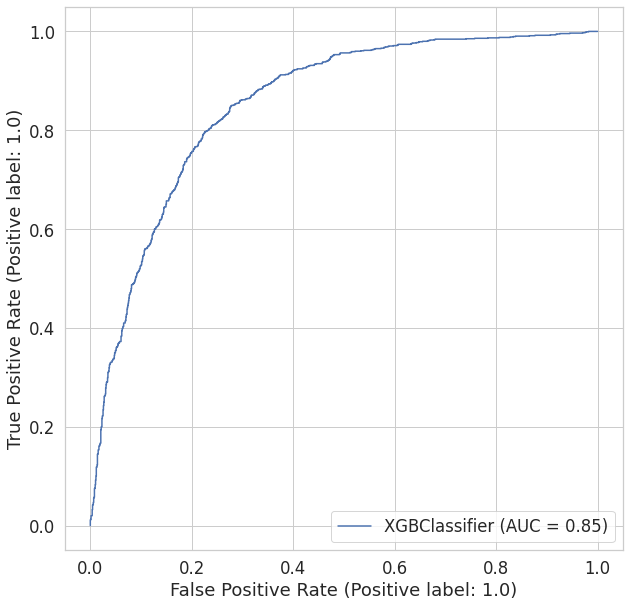

In [ ]:
RocCurveDisplay.from_estimator(xgb_model , X_test, y_test)

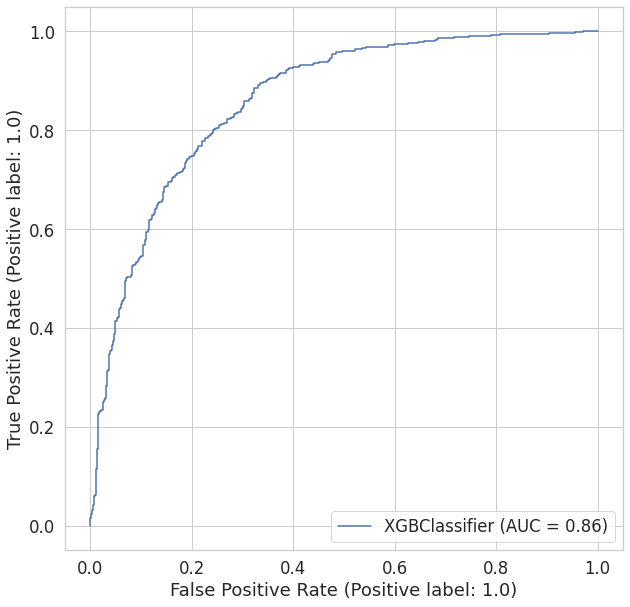

In [ ]:
RocCurveDisplay.from_estimator(xgb_model , X_valid, y_valid)

In [ ]:
y_pred_train_xgb = xgb_model.predict(X_train)

In [ ]:
matthews_corrcoef(y_train, y_pred_train_xgb)

0.6214379792639668

In [ ]:
matthews_corrcoef(y_test, y_pred_test_xgb)

0.568075985017852

In [ ]:
matthews_corrcoef(y_valid, y_pred_valid_xgb)

0.5502795255943341

In [ ]:
print(classification_report(y_train, y_pred_train_xgb))

              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82      4723
         1.0       0.78      0.82      0.80      4049

    accuracy                           0.81      8772
   macro avg       0.81      0.81      0.81      8772
weighted avg       0.81      0.81      0.81      8772



In [ ]:
print(classification_report(y_test, y_pred_test_xgb))

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79      1354
         1.0       0.75      0.80      0.77      1149

    accuracy                           0.78      2503
   macro avg       0.78      0.78      0.78      2503
weighted avg       0.79      0.78      0.78      2503



In [ ]:
print(classification_report(y_valid, y_pred_valid_xgb))

              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78       662
         1.0       0.75      0.78      0.77       589

    accuracy                           0.78      1251
   macro avg       0.77      0.78      0.77      1251
weighted avg       0.78      0.78      0.78      1251

